In [3]:
import numpy as np
import networkx as nx
from qwalk_simulator_helper import classical_random_walk, quantum_walk, create_cayley_tree, plot_cayley_tree_central, plot_graph, compute_probability_difference, visualize_prob_graph

### Define the Graph:
We can choose from the many NetworkX graph generators found at this link:

https://networkx.org/documentation/stable/reference/generators.html

Or we can specify any adjacency matrix.



In [4]:

# define any graph you'd like from the networkx library
G1 = nx.hypercube_graph(3)
G2 = nx.cycle_graph(10)
G3 = nx.grid_2d_graph(6, 6)
G4 = nx.balanced_tree(3,3)
G5 = nx.lollipop_graph(8,10)

# Or define a graph from an adjacency matrix (defined as an array) 
user_adj = np.array([
    [0,1,1,1,1,0,0],
    [1,0,1,1,1,0,0],
    [1,1,0,1,0,1,0],
    [1,1,1,0,1,1,1],
    [1,1,0,1,0,0,1],
    [0,0,1,1,0,0,0],
    [0,0,0,1,1,0,0]
    ])

# Another option is to use networkx to define a method to generate any large size graph 


G6 = nx.from_numpy_array(user_adj)

# We can implement methods to generate graphs of particular interest
caylay_graph = create_cayley_tree(3,4)

### To build more excitement for the Walk, Let's First Plot Our Graph

Let's start with the Cayley tree, as it also has an efficient discrete walk implementation found in this paper:

https://journals.aps.org/pra/abstract/10.1103/PhysRevA.86.042338




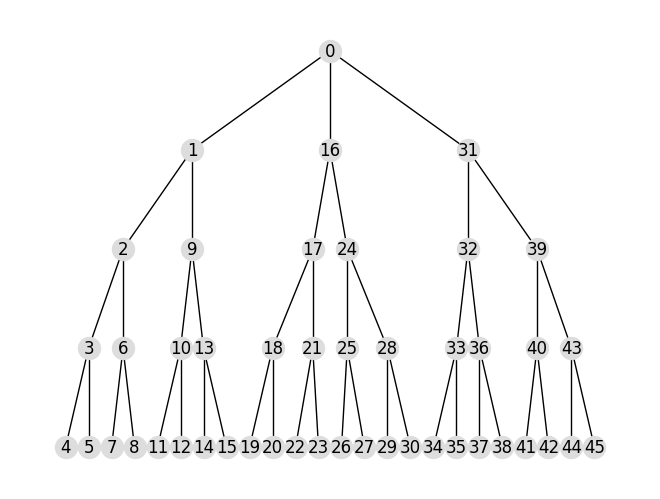

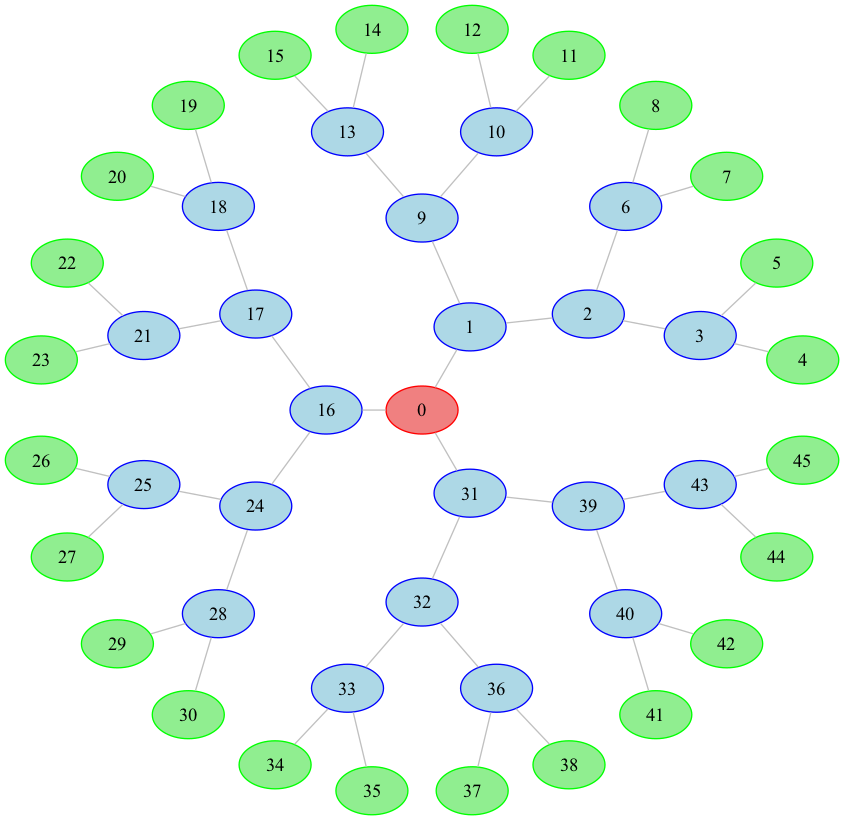

In [5]:
my_graph = caylay_graph

# Plot graphs
plot_graph(my_graph)

# Plot specific graphs
plot_cayley_tree_central(caylay_graph)

### Choose the node where you'd like to start your walk
we might want to set psi0 to a superposition for the initial state.

In [6]:
# Initial state vector (starting at node 0)
#Get the adjacency from nx
A = nx.adjacency_matrix(my_graph)

num_nodes = A.shape[0]
pos_0 = np.zeros(num_nodes)
pos_0[0] = 1  # Classical initial state
psi_0 = pos_0.copy()  # Quantum initial state

### Let's run a single step:

In [8]:
# Time parameters
t_classical = 10
t_quantum = np.pi/2

# Compute the classical random walk probabilities
pos_t = classical_random_walk(adjacency = A, initial_position = pos_0, time_step = t_classical)
prob_classical = pos_t

# Compute the quantum walk probabilities
psi_t = quantum_walk(adjacency = A, initial_position = psi_0, time_step = t_quantum)
prob_quantum = np.abs(psi_t)**2

#Compute the difference between classical and quantum
prob_diff = compute_probability_difference(p_quantum=prob_quantum, p_classical=prob_classical)

print(f"==== Classical State Vector ====\n{prob_classical}"
      f"\n\n==== Quantum State Vector ====\n{prob_quantum}"
      f"\n\n==== Difference Vector ====\n{prob_diff}")

==== Classical State Vector ====
[0.02181548 0.0217949  0.02176205 0.02173636 0.02172463 0.02172463
 0.02173636 0.02172463 0.02172463 0.02176205 0.02173636 0.02172463
 0.02172463 0.02173636 0.02172463 0.02172463 0.0217949  0.02176205
 0.02173636 0.02172463 0.02172463 0.02173636 0.02172463 0.02172463
 0.02176205 0.02173636 0.02172463 0.02172463 0.02173636 0.02172463
 0.02172463 0.0217949  0.02176205 0.02173636 0.02172463 0.02172463
 0.02173636 0.02172463 0.02172463 0.02176205 0.02173636 0.02172463
 0.02172463 0.02173636 0.02172463 0.02172463]

==== Quantum State Vector ====
[0.0842567  0.00109638 0.03939795 0.02951939 0.01340974 0.01340974
 0.02951939 0.01340974 0.01340974 0.03939795 0.02951939 0.01340974
 0.01340974 0.02951939 0.01340974 0.01340974 0.00109638 0.03939795
 0.02951939 0.01340974 0.01340974 0.02951939 0.01340974 0.01340974
 0.03939795 0.02951939 0.01340974 0.01340974 0.02951939 0.01340974
 0.01340974 0.00109638 0.03939795 0.02951939 0.01340974 0.01340974
 0.02951939 0.0134

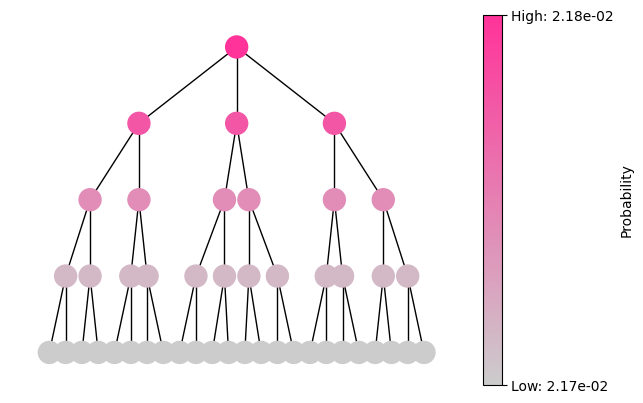

In [9]:
#Claasical 
visualize_prob_graph(my_graph,prob_classical, labels=False)

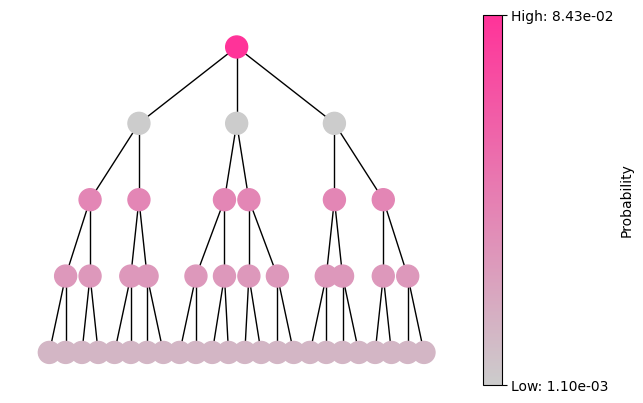

In [10]:
#Quantum  
visualize_prob_graph(my_graph,prob_quantum, labels=False)

#### At the Bottom of the Page, There Is an Attempt to Simulate an Interactive Walk; We Still Need to Fix the Bug That Makes the Figure Not Show.
#### Until It Works, We Can Just Print the Results Based on a Timestep and Number of Steps:

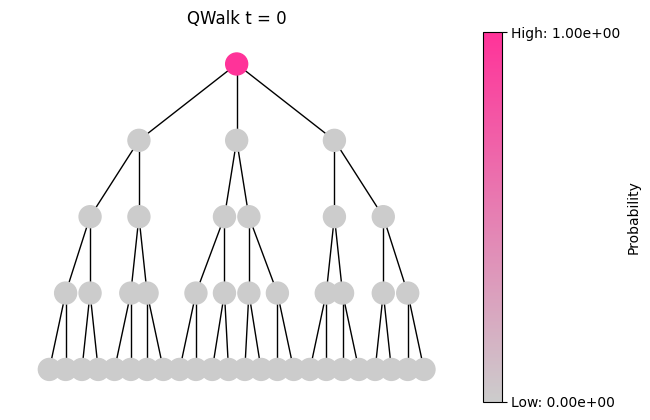

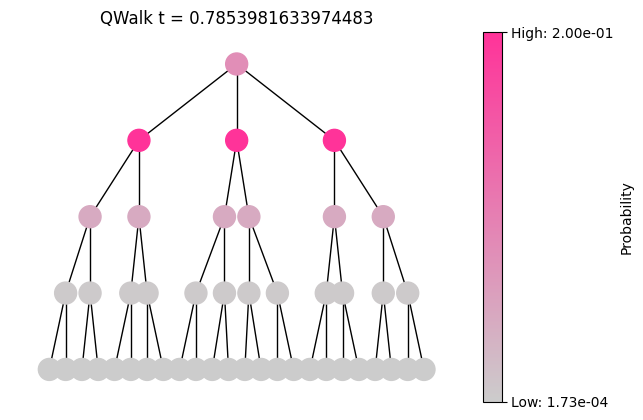

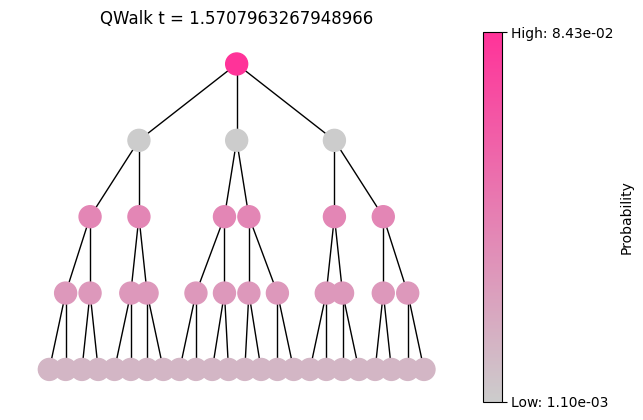

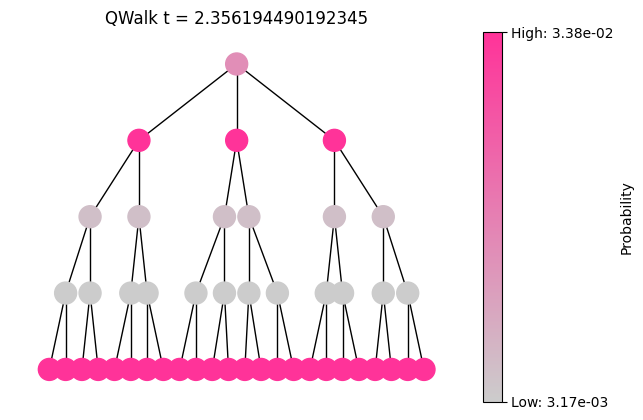

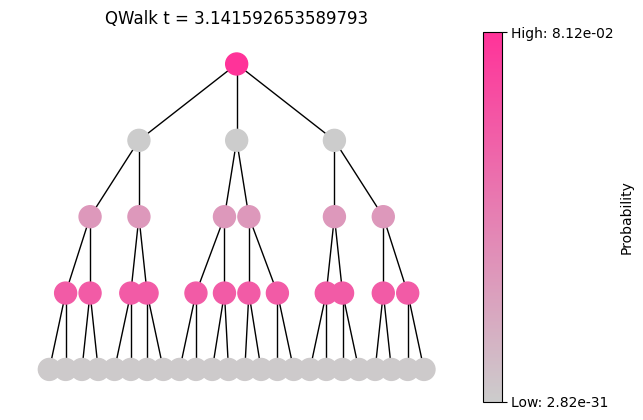

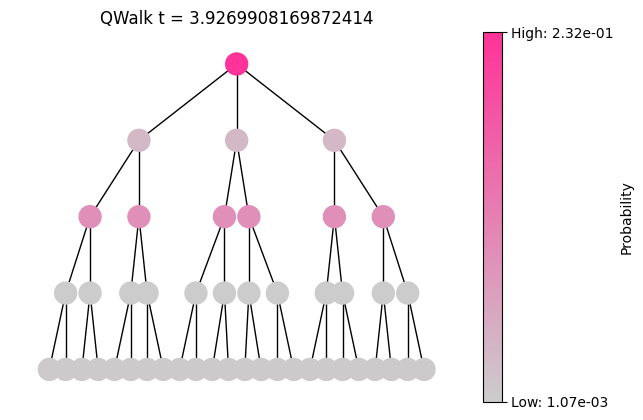

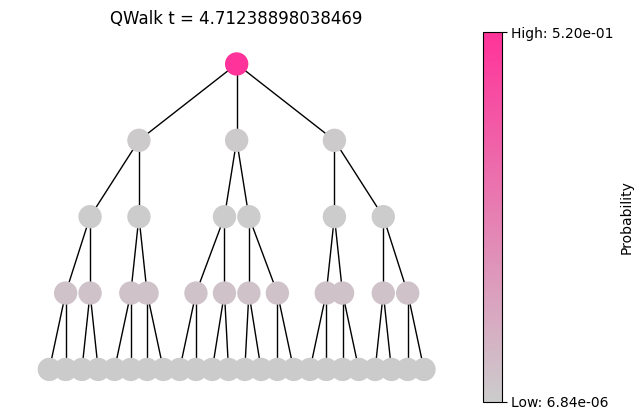

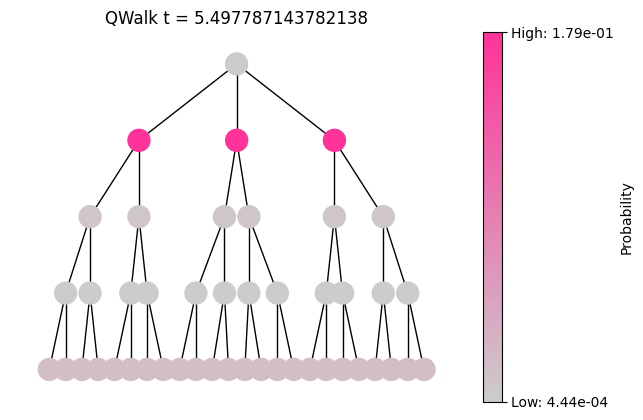

In [19]:
t_n = 0
timestep = np.pi/4
n = 8

#Quantum
for i in range(8):

    # Compute the quantum walk probabilities
    psi_t = quantum_walk(adjacency = A, initial_position = psi_0, time_step = t_n)
    prob_quantum = np.abs(psi_t)**2
    title = f"QWalk t = {t_n}"
    visualize_prob_graph(my_graph,prob_quantum, labels=False, title=title)
    t_n += timestep

#C#lassical
# t_n = 0
# for i in range(8):
# 
#     # Compute the quantum walk probabilities
#     pos_t = classical_random_walk(adjacency = A, initial_position = pos_0, time_step = t_n)
#     title = f"Classical Walk, t = {t_n}"
#     visualize_prob_graph(my_graph,pos_t, labels=False, title=title)
#     t_n += timestep
    


### It's time to put it all together and try out different things 

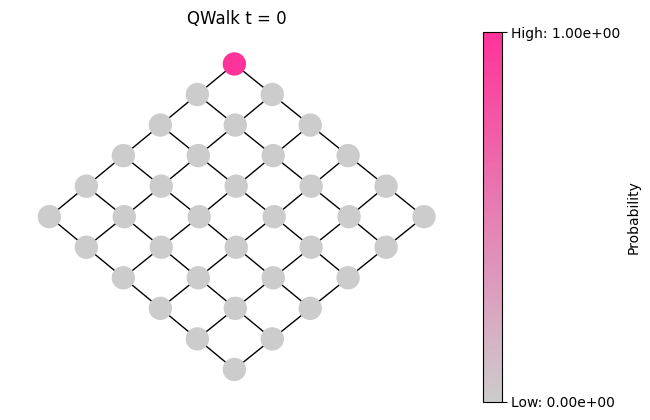

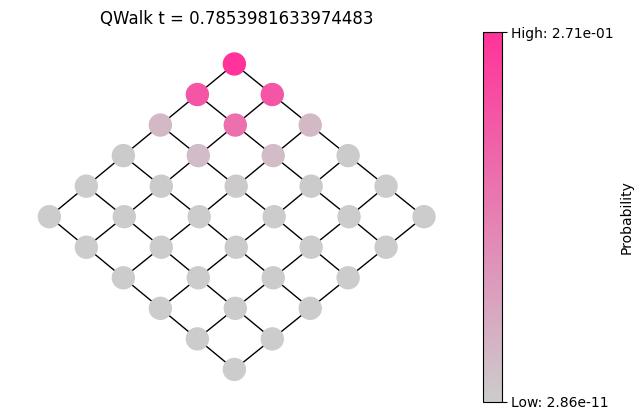

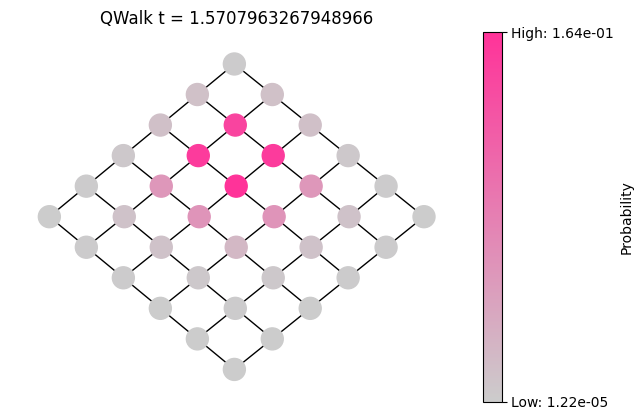

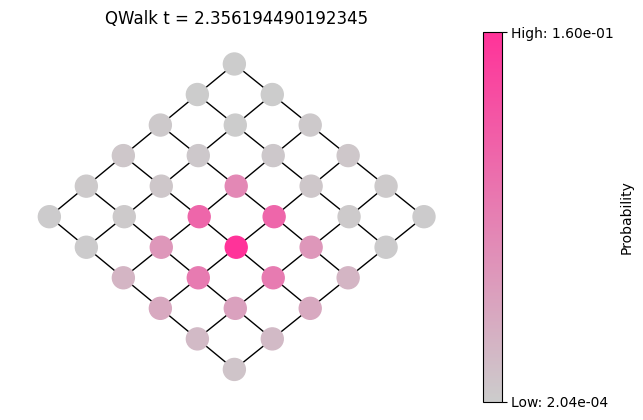

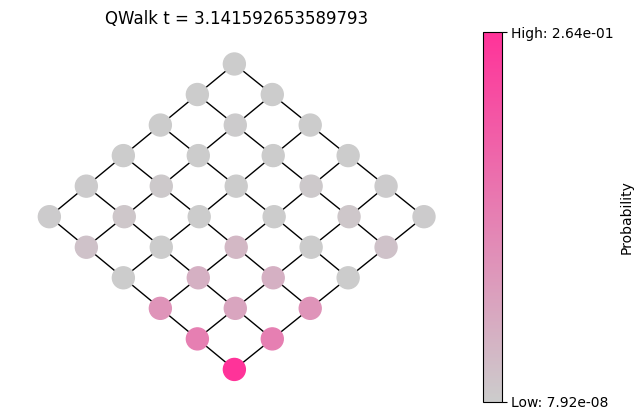

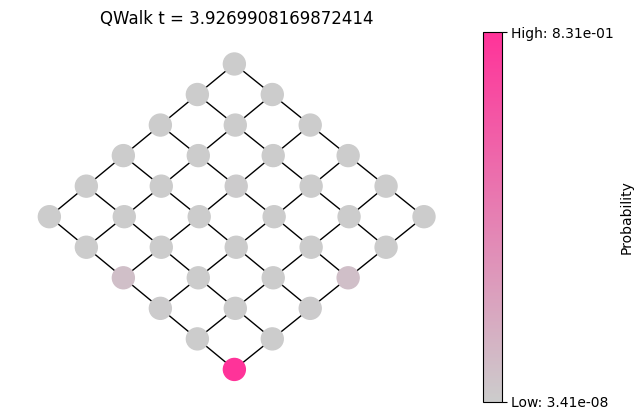

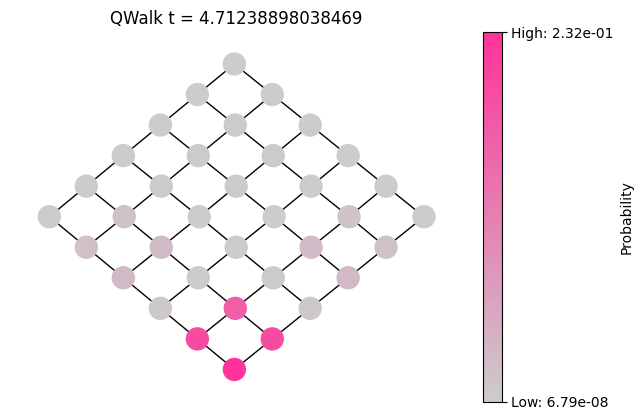

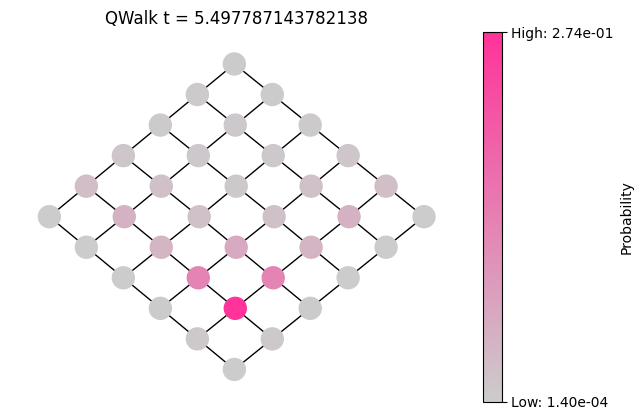

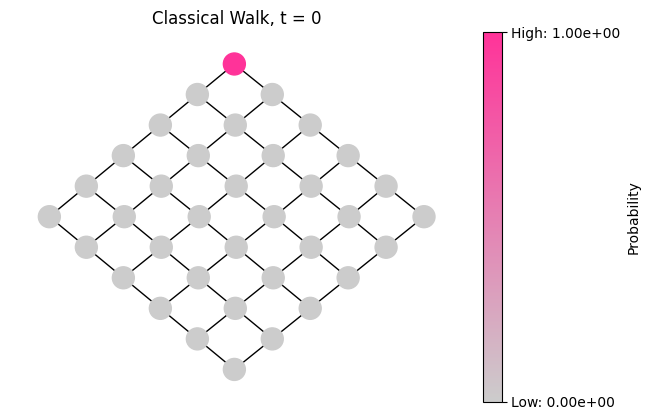

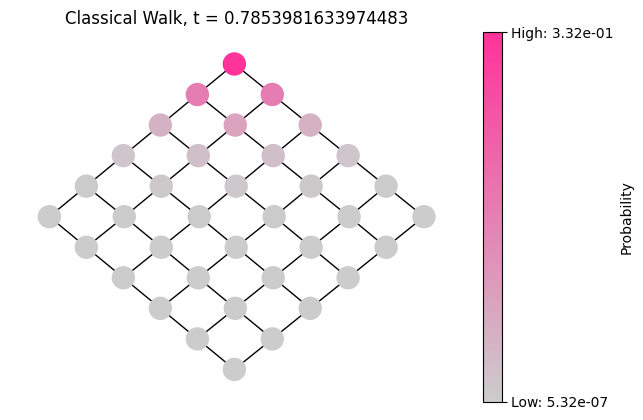

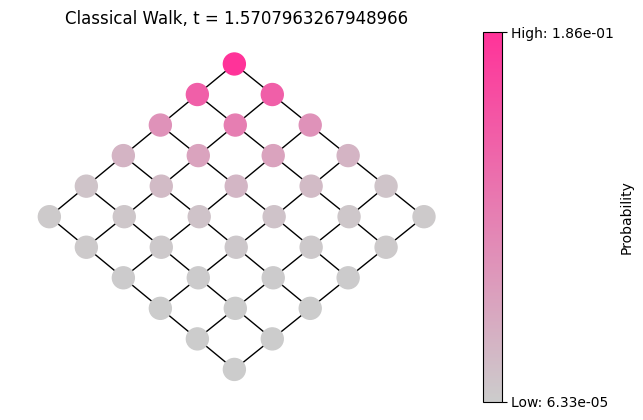

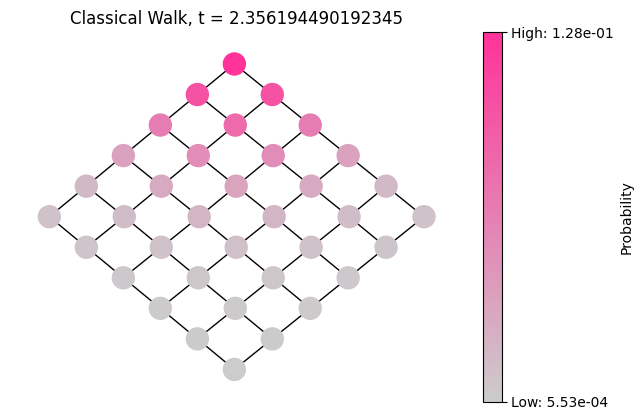

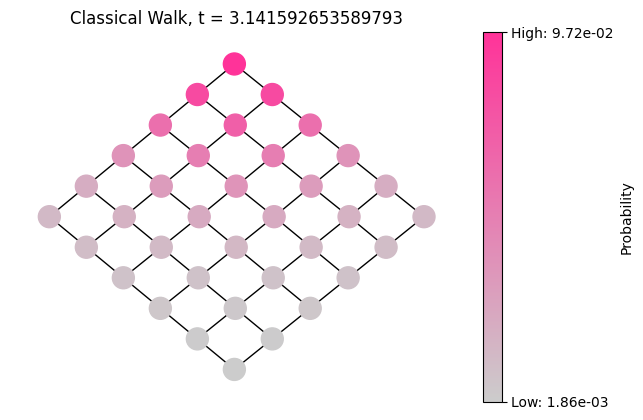

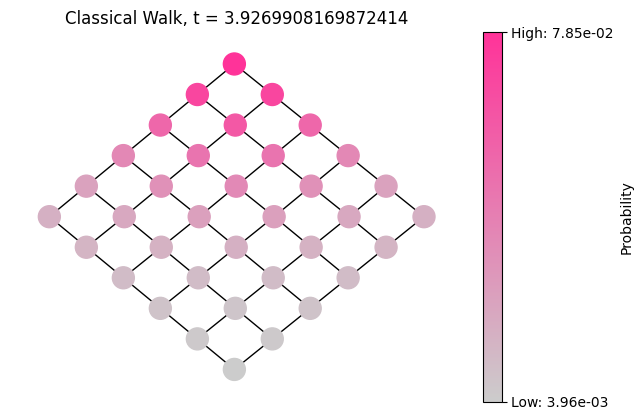

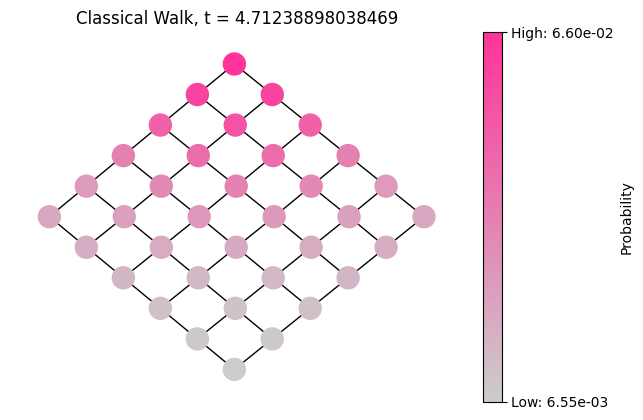

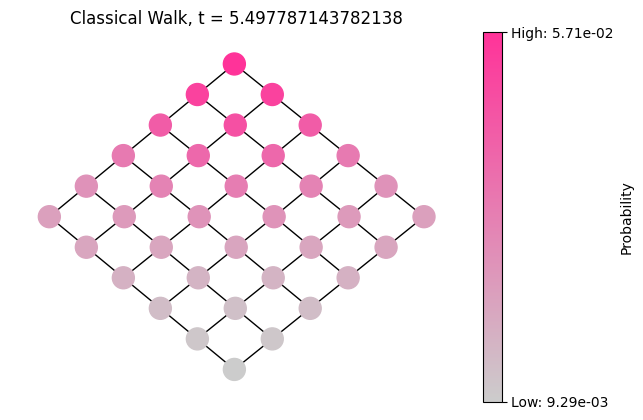

In [22]:
G1 = nx.hypercube_graph(3)
G2 = nx.cycle_graph(10)
G3 = nx.grid_2d_graph(6, 6)
G4 = nx.balanced_tree(3,3)
G5 = nx.lollipop_graph(8,10)

my_graph = G3

#Get the adjacency from nx
A = nx.adjacency_matrix(my_graph)

# Initial state vector (starting at node 0)
num_nodes = A.shape[0]
pos_0 = np.zeros(num_nodes)
pos_0[0] = 1  # Classical initial state
psi_0 = pos_0.copy()  # Quantum initial state

t_n = 0
timestep = np.pi/4
n = 8

#Quantum
for i in range(8):

    # Compute the quantum walk probabilities
    psi_t = quantum_walk(adjacency = A, initial_position = psi_0, time_step = t_n)
    prob_quantum = np.abs(psi_t)**2
    title = f"QWalk t = {t_n}"
    visualize_prob_graph(my_graph,prob_quantum, labels=False, title=title)
    t_n += timestep

#Classical
t_n = 0
for i in range(8):

    # Compute the quantum walk probabilities
    pos_t = classical_random_walk(adjacency = A, initial_position = pos_0, time_step = t_n)
    title = f"Classical Walk, t = {t_n}"
    visualize_prob_graph(my_graph,pos_t, labels=False, title=title)
    t_n += timestep


### Will fix this soon :) 

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx

# Create an output widget to display results
output = widgets.Output()

def update_plot(step_value):
    global t_classical, t_quantum
    t_classical += step_value
    t_quantum += step_value

    # Compute new probabilities
    pos_t = classical_random_walk(A, pos_0, t_classical)
    psi_t = quantum_walk(A, psi_0, t_quantum)
    prob_classical = pos_t
    prob_quantum = np.abs(psi_t)**2
    prob_diff = compute_probability_difference(prob_quantum, prob_classical)

    # Clear previous output and display new
    with output:
        clear_output(wait=True)

        # Print results
        print(f"==== Classical State Vector ====\n{prob_classical}"
              f"\n\n==== Quantum State Vector ====\n{prob_quantum}")

        # # Plot Classical Walk Probabilities
        # visualize_prob_graph(my_graph, prob_classical, title="Classical Walk Probabilities")
        # plt.show()
        
        # Plot Quantum Walk Probabilities
        visualize_prob_graph(my_graph, prob_quantum, title="Quantum Walk Probabilities")
        plt.show()

# Create slider and button widgets
step_slider = widgets.FloatSlider(value=np.pi/2, min=0, max=2*np.pi, step=0.01, description="Step Size:")
next_button = widgets.Button(description="Next Step")

# Define button click event to advance the time step
def on_next_button_clicked(b):
    step_value = step_slider.value
    update_plot(step_value)

# Attach the click event to the button
next_button.on_click(on_next_button_clicked)

# Display the widgets and output area
display(step_slider, next_button, output)